# **Foundations of Deep Learning - E05**<br/>
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

prof. Paolo Napoletano, 
dr. Marco Buzzelli

**Outline:**
* We will define a **Recurrent Neural Network** (RNN) to forecast the weather
  * We will use a **Long Short-Term Memory** (LSTM) module
  * We will predict the temperature at time `t`, given some history of temperature and other readings
* An important aspect will be arranging the data for the data loader

**Before running any command:**
* Runtime -> Change runtime type -> Hardware accelerator: GPU

In [1]:
from google.colab import drive
from shutil import copyfile
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

# Import and analyze data

**Note:**
* Before continuing, you must import this file into your own Google Drive:<br/>
https://drive.google.com/file/d/1g5q57gxyxBASrb2weYYo7q97VPtB1DKO/view?usp=sharing<br/>
(Top-right corner -> Add shortcut to Drive -> My Drive -> Add shortcut here)
* If the link no longer works, you can retrieve the original dataset from:<br/>
https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip

In [2]:
# Link Google Drive account and download csv dataset
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/climate.csv', 'climate.csv')

Mounted at /content/gdrive


'climate.csv'

In [3]:
# Import csv dataset
df_climate = pd.read_csv('climate.csv')
df_climate

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


**Note**:
* We are dealing with data that can be summarized as a table (as in E03)
* However, now we have an explicit time dependency:
  * Every row does not correspond to an independent observation, but to a specific timestamp.
  * Let's indicate the time column as the index for our dataframe.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.index.html

In [4]:
# Change dataframe index to the time information
df_climate.index = df_climate['Date Time']
df_climate = df_climate.drop('Date Time', axis=1)
df_climate

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [5]:
# Print aggregate statistics
df_climate.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


Text(0, 0.5, 'T (degC)')

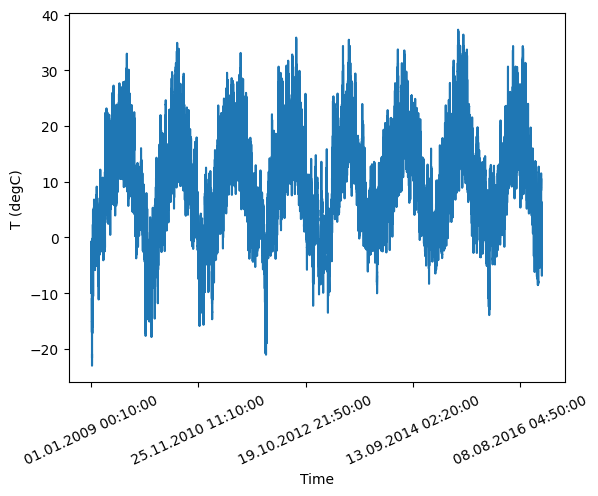

In [6]:
# Visualize any of the features as a function of time
feature_id = 1
df_climate.iloc[:, feature_id].plot(rot=25)
plt.xlabel('Time')
plt.ylabel(df_climate.columns[feature_id])

https://pandas.pydata.org/docs/user_guide/visualization.html

**Note:**
* Our goal will be to predict the temperature at time `t`, given some history (previous values) of temperature and other readings.
* This is can be seen as a regression task.
* Where do we get the target?
  * We do not need an external source: we will repurpose the available data itself.
  * I.e. the temperature information will work both as input and as target (but we need to structure the data appropriately)

Given P elements in the past, we want to predict 1 element that is F positions in the future:
```
[][][][][][]····[]
\__________/\____/
    PAST    FUTURE
```

We can have this structure move across all our dataset, and build a large number of input-target pairs.

In [7]:
past = 720
future = 72

# Preprocessing

In [8]:
df = df_climate

## Define training and validation sets

In [9]:
# Specify the ratio of training-validation data and compute the corresponding number of elements
split_fraction = 0.7
N_train = int(split_fraction * df.shape[0])
N_train

294385

In [10]:
# Whole dataset
df.shape

(420551, 14)

**Note:**
* We will split the available data by taking the first N datapoints as training and the remaining as validation.
* When we do this we must always be aware of any bias in the data:
  * For example, if the temporal range is not large enough, training and validation data might actually cover totally different distributions.

```
df:         [][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][]
training:   [][][][][][][][][][][][][][][][][][][][]
validation:                                         [][][][][][][][][][][][][][]
```
(This visualization is shown horizontally for the sake of space.<br/>
Keep in mind that the time steps are actually along the first dimension, which is normally interpreted as the rows of a matrix)


## Standardize data

In [11]:
# Apply z-score standardization based on training data
data_mean = df[:N_train].mean(axis=0)
data_std = df[:N_train].std(axis=0)
df = (df - data_mean) / data_std

**Note:**
* We compute the statistics (mean and standard deviation) for all variables, using all the examples from the training set.
  * I.e. for any variable, we analyze all training values and extract mean and standard deviation.
* We then use those **training-specific** statistics to normalize the **whole** dataset (both training set and validation set).

In [12]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,0.067071,0.039582,0.034205,0.051223,0.006292,0.028864,0.042101,0.009314,0.040847,0.040901,-0.022811,-0.295629,-0.217853,0.014843
std,1.007433,0.973322,0.974819,0.965278,0.995111,1.006017,0.994167,1.016914,0.994227,0.994096,0.976033,42.772441,29.823492,0.988683
min,-9.046402,-3.711197,-3.736104,-4.246323,-3.802237,-1.612458,-2.035436,-0.830161,-2.026262,-2.034001,-3.846661,-6536.215061,-4322.291371,-1.978268
25%,-0.537110,-0.664136,-0.660733,-0.625100,-0.645890,-0.724607,-0.747631,-0.649491,-0.746112,-0.745435,-0.720442,-0.761100,-0.778118,-0.553670
50%,0.111332,0.036098,0.031598,0.089105,0.205103,-0.199436,-0.117985,-0.375371,-0.121009,-0.118755,-0.078303,-0.257870,-0.259576,0.281242
75%,0.730847,0.735177,0.726221,0.784667,0.815113,0.551922,0.711247,0.270474,0.706222,0.709777,0.629272,0.461031,0.509595,0.691855
max,3.217344,3.255329,3.226178,2.654795,1.455321,6.553689,4.505756,8.724597,4.572875,4.542616,4.310466,17.211416,8.616138,2.127859


## Define targets

### Training set

For every block of P elements in the training set, we want to take the corresponding future *target* at position P+F.<br/>
This prepares the data for our dataloader, which will take a random block of P elements from the training set, and expects to find the corresponding target in a second variable.

```

df:         [][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][]

training:   [][][][][][][][][][][][][][][][][][][][]
            [PAST]-F->[]
                                              [PAST]-F->[]

inputs:     [][][][][][][][][][][][][][][][][][][][]
targets:              [][][][][][][][][][][][][][][][][][]
```

In [13]:
input_start = 0
input_end = N_train

target_start = past + future
target_end = N_train + future # Equivalent to: target_start + N_train - past

In [14]:
x_train = df[input_start:input_end] # inputs
y_train = df[target_start:target_end][['T (degC)']]  # targets

In [15]:
# Shape of the training data: 300K datapoints, with 14 variables (including temperature)
x_train.shape

(294385, 14)

In [16]:
# Shape of the training targets: 300K datapoints representing the temperature in the future
y_train.shape

(293665, 1)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

**Note:**
* The targets are (slightly) fewer than the inputs, because they are associated to each input block, not to each input element.
  * The difference is the length of the input block, i.e. `past`.

### Validation set

For the validation set, we follow a similar line of reasoning to select a all the input blocks for which we can have a corresponding target.

```
df:         [][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][]

validation:                                         [][][][][][][][][][][][][][]
                                                    [PAST]-F->[]
                                                                    [PAST]-F->[]

inputs:                                             [][][][][][][][][][][]
targets:                                                      [][][][][][][][][]
```

In [17]:
input_start = N_train
input_end = len(df) - future

target_start = N_train + (past+future)
target_end = len(df)

In [18]:
x_val = df[input_start:input_end]
y_val = df[target_start:target_end][['T (degC)']]

In [19]:
# Shape of the validation data: 100K datapoints, with 14 variables (including temperature)
x_val.shape

(126094, 14)

In [20]:
# Shape of the validation data: 100K datapoints representing the temperature in the future
y_val.shape

(125374, 1)

## Data loaders (+ dimensionality reduction)

**Note:**
* The climate observations are recorded every 10 minutes, that means 6 times per hour.
* We will resample one point per hour since no drastic change is expected within 60 minutes.
* We do this via the `sampling_rate` argument in `timeseries_dataset_from_array` utility.

In [21]:
step = 6
batch_size = 256

In [22]:
# Recompute the 'past' length, taking into account the sampling step
sequence_length = int(past / step)
sequence_length

120

In [23]:
# Training dataloader
train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [24]:
# Validation dataloader
val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [25]:
for batch in train_dataset.take(1):
    inputs, targets = batch

# print("Input shape:", inputs.numpy().shape)
# print("Target shape:", targets.numpy().shape)

**Note:**
* We are taking one batch from the training dataset to inspect the shape of the involved data.
  * As input we have a batch of 256 blocks, each 120-elements long, sampled with a sliding window over our original dataframe, and characterized by 14 features.
  * As target we have, for each of the 256 blocks, an expected temperature in the future.

https://keras.io/api/preprocessing/timeseries/

# Model definition and training

In [26]:
learning_rate = 0.001
epochs = 3

## Architecture v1

In [27]:
# Architecture definition v1
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
x = inputs
x = keras.layers.LSTM(1)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [28]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 1)                 64        
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


https://keras.io/api/layers/recurrent_layers/lstm/

**Note:**
* An LSTM layer:
  * takes as input a tensor with shape `[batch, time, feature]`
  * returns a tensor with shape `[batch, new_feature]`

In [29]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/3
1148/1148 [==============================] - 67s 51ms/step - loss: 0.5971 - val_loss: 0.3759
Epoch 2/3
1148/1148 [==============================] - 56s 49ms/step - loss: 0.4116 - val_loss: 0.3020
Epoch 3/3
1148/1148 [==============================] - 55s 48ms/step - loss: 0.3559 - val_loss: 0.2810


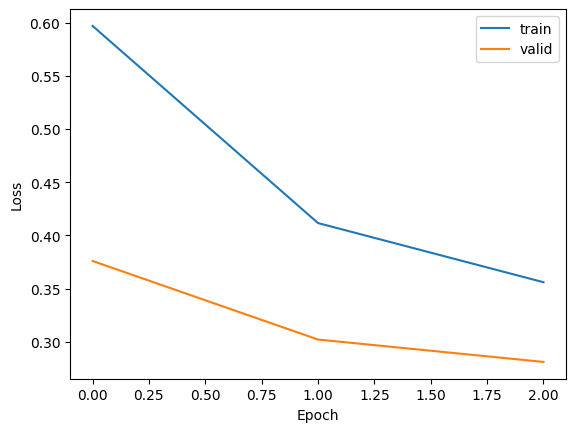

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

**Note:**
* The network is learning, and additional epochs are likely to improve the performance.
* However, the LSTM layer by default uses a `tanh` activation function, which forces the output to be between -1 and +1
* Our data was z-score standardized, which means that it is reasonably around -1 and +1, but not strictly in that range.
* We will now add a fully-connected layer to add complexity AND to map to an arbitrary output range.

## Architecture v2

In [31]:
# Architecture definition v2
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
x = inputs
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dense(1)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/3
1148/1148 [==============================] - 62s 52ms/step - loss: 0.1932 - val_loss: 0.1426
Epoch 2/3
1148/1148 [==============================] - 61s 53ms/step - loss: 0.1258 - val_loss: 0.1314
Epoch 3/3
1148/1148 [==============================] - 65s 56ms/step - loss: 0.1154 - val_loss: 0.1281


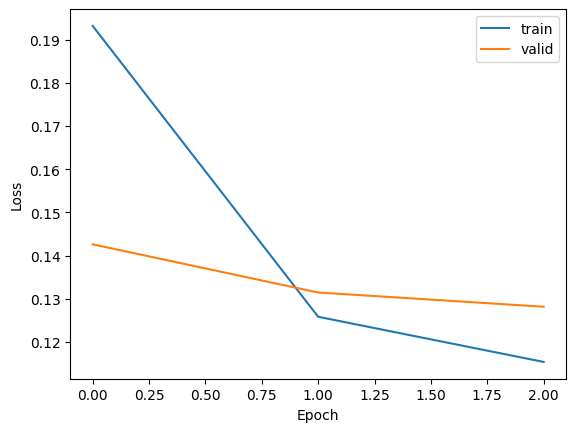

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

**Note:**
* The performance has improved both for the training and validation set.
* We start observing symptoms of overfitting in the validation set.
* At this point, we are supposed to introduce techniques to fight the overfitting phenomenon. This excercise is left to the student.
* For completeness, we will now instead add a second LSTM module.
  * Note that by default an LSTM module removes the time dimension (see above summaries).
  * If we want to stack multiple LSTMs, we must force them to preserve the time dimension using `return_sequences=True`.

## Architecture v3

In [35]:
# Architecture definition v3
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
x = inputs
x = keras.layers.LSTM(32, return_sequences=True)(x)
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dense(1)(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [36]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 120, 32)           6016      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,369
Trainable params: 14,369
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = net.fit(
    train_dataset,
    epochs = epochs,
    validation_data = val_dataset,
)

Epoch 1/3
1148/1148 [==============================] - 72s 59ms/step - loss: 0.1773 - val_loss: 0.1437
Epoch 2/3
1148/1148 [==============================] - 67s 59ms/step - loss: 0.1285 - val_loss: 0.1519
Epoch 3/3
1148/1148 [==============================] - 66s 58ms/step - loss: 0.1171 - val_loss: 0.1464


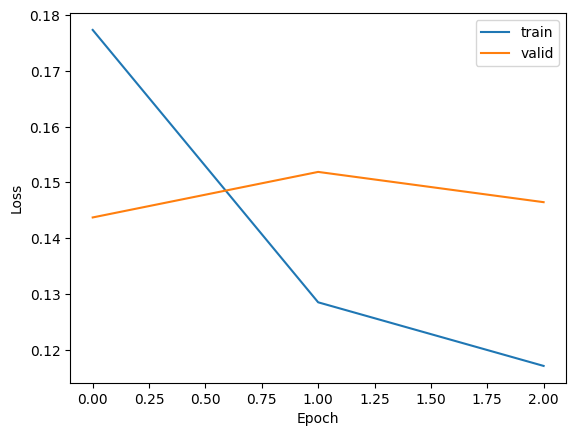

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

**Note:**
* As expected, the increased complexity has made the overfitting even worse.

## Verify output

We can fetch an input-target pair from the validation dataset and visually judge the estimation results

In [39]:
for batch in val_dataset.take(1):
    inputs, targets = batch

In [40]:
out = net.predict(inputs[0,None])

1/1 [==============================] - 1s 657ms/step


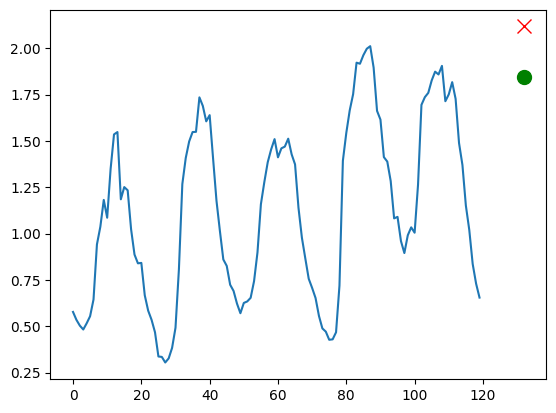

In [41]:
plt.plot(inputs[0,:,1])
plt.plot(120+12, targets[0], 'rx', markersize=10)
plt.plot(120+12, out[0], 'go', markersize=10)

# Resources

https://keras.io/examples/timeseries/timeseries_weather_forecasting/